In [71]:
%matplotlib inline
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, \
    MaxPooling2D, \
    Convolution2D, \
    Dropout, \
    BatchNormalization, \
    ZeroPadding2D
from keras.preprocessing import image
import matplotlib.pyplot as plt

## Simple Linear Model

### Create Dummy Dataset

In [13]:
n = 1000
p = 3
X = np.random.rand(n, p)
w = np.array([5, 7, 2])
y = np.dot(X, w)

### Fit Model

In [46]:
model = Sequential([Dense(1, input_dim=3)])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(X, y, nb_epoch=100)

Epoch 1/100
1000/1000 [==============================] - 0s - loss: 25.1412     
Epoch 2/100
1000/1000 [==============================] - 0s - loss: 4.4256     
Epoch 3/100
1000/1000 [==============================] - 0s - loss: 2.2725     
Epoch 4/100
1000/1000 [==============================] - 0s - loss: 1.9321     
Epoch 5/100
1000/1000 [==============================] - 0s - loss: 1.7843     
Epoch 6/100
1000/1000 [==============================] - 0s - loss: 1.6588     
Epoch 7/100
1000/1000 [==============================] - 0s - loss: 1.5427     
Epoch 8/100
1000/1000 [==============================] - 0s - loss: 1.4380     
Epoch 9/100
1000/1000 [==============================] - 0s - loss: 1.3400     
Epoch 10/100
1000/1000 [==============================] - 0s - loss: 1.2498     
Epoch 11/100
1000/1000 [==============================] - 0s - loss: 1.1663     
Epoch 12/100
1000/1000 [==============================] - 0s - loss: 1.0891     
Epoch 13/100
1000/1000 [============

In [47]:
model.layers[0].get_weights()

[array([[ 4.87689924],
        [ 6.86038113],
        [ 1.86813855]], dtype=float32), array([ 0.20528407], dtype=float32)]

## DogsVsCats Linear Model using VGG outputs

In [52]:
train_path = '/mnt/data/dogscats/sample/train/'
valid_path = '/mnt/data/dogscats/sample/valid/'

In [56]:
def get_batches(path, batch_size=4, idg=image.ImageDataGenerator(), shuffle=True, class_mode='categorical'):
    return idg.flow_from_directory(path, batch_size=batch_size, target_size=(224, 224), shuffle=shuffle, class_mode=class_mode)

In [57]:
abc = next(get_batches(train_path))

Found 16 images belonging to 2 classes.


In [70]:
abc[0][0].shape

(224, 224, 3)

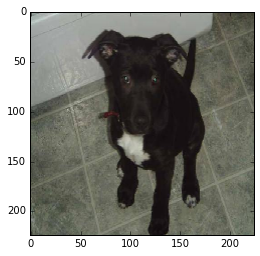

In [73]:
plt.imshow(abc[0][0].astype('uint8'))